# Etude de faisabilité d'un Classifieur automatique des biens de consommation 

## Import of librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #opencv pour SIFT
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import pickle
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
pd.options.display.max_rows = 999
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model
from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
import time
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow_text 
import gensim
# Bert
import os
import transformers
import re
from transformers import AutoTokenizer

In [2]:
os.environ["TF_KERAS"]='1'

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

## Processing of the categories

In [3]:
def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

def split_categories_1(category):
    return split_categories(category,0)

def split_categories_2(category):
    return split_categories(category,1)

def split_categories_3(category):
    return split_categories(category,2)

def split_categories(category, level):
    '''FOnction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

## cleaning up the text : 

In [22]:
###################### Tokenizer ####################################
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

#### Stop words = NLTK + ponctuations librairies + free StopWords list ####
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)
stop_w = stopwords_combined

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

#################### lower case et alpha  ###############################
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

################ Lemmatizer (base d'un mot) ############################
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

################ numbers removal ############################
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern,repl=" ", string=text)
    return without_number

################ numbers adverbs ############################
def remove_adverbs(text):
    adverbs_pattern = r'\w+ly\b'
    without_adverbs = re.sub(pattern=adverbs_pattern,repl=" ", string=text)
    return without_adverbs

######## Text preparation function for bag of words (Countvectorizer et Tf_idf, Word2Vec) #######
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)  # Tokenization
    sw = stop_word_filter_fct(word_tokens)  # StopWords
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

######## Text preparation function for bag of words with lemmatization ##################
def transform_bow_lem_removal_numbers_fct(desc_text) :
    numbers_result = remove_numbers(desc_text)
    word_tokens = tokenizer_fct(numbers_result)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

######## Text preparation function for bag of words with lemmatization ##################
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

######## Text preparation function for bag of words with lemmatization and adverbs ##################
def transform_bow_lem_removal_numbers_adverbs_fct(desc_text) :
    numbers_result = remove_numbers(desc_text)
    adverbs_result= remove_adverbs(numbers_result)
    word_tokens = tokenizer_fct(adverbs_result)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


#########  Text preparation function for Deep learning (USE et BERT) ####################
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

#################################################### BERT ##################################################
# preparation of sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# creation of features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode) :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace   package de transformers de Hugging Face.
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub 
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

####################################################### USE ###########################################################

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

## common functions 

In [5]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    # find tsne coords for 2 dimensions
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,Model) :
    fig = plt.figure(figsize=(20,15))
    
    ax = fig.add_subplot(211)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Real categories")
    plt.title('repreentation produits par categories réelles')
    
    ax = fig.add_subplot(212)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Model clusters")
    plt.title('Représentation produits par clustering. Modèle '+ " " + Model)
    
    
    plt.show()
    print("ARI : ", ARI)
    

def TSNE_visu_fct_BERT(X_tsne, y_cat_num, labels, ARI,Model,mode) :
    fig = plt.figure(figsize=(20,15))
    
    ax = fig.add_subplot(211)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Real categories")
    plt.title('repreentation produits par categories réelles')
    
    ax = fig.add_subplot(212)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Model clusters")
    plt.title('Représentation produits par clustering. Modèle '+ " " + Model + " " + mode)
    
    
    plt.show()
    print("ARI : ", ARI)

In [6]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [7]:
data.shape

(1050, 15)

In [8]:
data.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [9]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [10]:
data['product_category_tree'].sample(10)

722     ["Home Furnishing >> Bed Linen >> Blankets, Qu...
664     ["Baby Care >> Feeding & Nursing >> Utensils >...
1044    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
231     ["Home Decor & Festive Needs >> Showpieces >> ...
604                ["Computers >> Laptops >> HP Laptops"]
456         ["Home Furnishing >> Bed Linen >> Bedsheets"]
247     ["Kitchen & Dining >> Cookware >> Pots & Pans ...
545     ["Watches >> Wrist Watches >> Kool Kidz Wrist ...
761     ["Watches >> Wrist Watches >> Perucci Wrist Wa...
623     ["Baby Care >> Infant Wear >> Baby Girls' Clot...
Name: product_category_tree, dtype: object

In [11]:
Total_products_categories=data['product_category_tree'].nunique()

In [12]:
data = detail_categories(data)

In [13]:
products_categories_lvl_1= data['cat_lvl_1'].nunique()
products_categories_lvl_2= data['cat_lvl_2'].nunique()
products_categories_lvl_3= data['cat_lvl_3'].nunique()

In [14]:
# synthesis :
dict_model={}
dict_model = [Total_products_categories, 
              products_categories_lvl_1, 
              products_categories_lvl_2,
              products_categories_lvl_3
             ]                        

synthesis = pd.DataFrame(dict_model, 
                        index=["Total_products_categories",
                               "products_category_lvl_1",
                               "products_category_lvl_2",
                               "products_category_lvl_3"
                              ]
                        )
synthesis.columns = ["Synthesis"] 
synthesis.round(2)   

,Synthesis
Total_products_categories,642
products_category_lvl_1,7
products_category_lvl_2,62
products_category_lvl_3,242


In [15]:
# catégories identification by level
cat_1 = pd.DataFrame(data['cat_lvl_1'].value_counts())
cat_2 = pd.DataFrame(data['cat_lvl_2'].value_counts())
cat_3 = pd.DataFrame(data['cat_lvl_3'].value_counts())

In [16]:
print("Number of products in category 1 :\n")
cat_1

Number of products in category 1 :



,cat_lvl_1
Home Furnishing,150
Home Decor & Festive Needs,150
Computers,150
Beauty and Personal Care,150
Kitchen & Dining,150
Watches,150
Baby Care,150


In [17]:
print("Number of products in category 2 :\n")
cat_2

Number of products in category 2 :



,cat_lvl_2
Wrist Watches,149
Laptop Accessories,87
Infant Wear,84
Coffee Mugs,74
Showpieces,71
Bed Linen,65
Fragrances,65
Network Components,49
Table Decor & Handicrafts,27
Cookware,27


In [18]:
print("Number of products in category 3 :\n")
cat_3

Number of products in category 3 :



,cat_lvl_3
Deodorants,65
"Blankets, Quilts & Dohars",57
Routers,49
Baby Girls' Clothes,49
USB Gadgets,38
Baby Boys' Clothes,35
Ethnic,34
Prithish Coffee Mugs,26
Pots & Pans,24
Showpieces,23


In [19]:
data.to_csv('data_categories.csv')

In [20]:
data[['description']].head(3)

,description
0,Key Features of Elegance Polyester Multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...


## cleaning up the text  : 

In [23]:
data['description_bow'] = data['description'].apply(lambda x : transform_bow_fct(x))
data['description_bow_lem'] = data['description'].apply(lambda x : transform_bow_lem_fct(x))
data['description_bow_lem_removal_numbers'] = data['description'].apply(lambda x : transform_bow_lem_removal_numbers_fct(x))
data['description_dl'] = data['description'].apply(lambda x : transform_dl_fct(x))
data['description_bow_lem_removal_numbers_adverbs'] = data['description'].apply(lambda x : transform_bow_lem_removal_numbers_adverbs_fct(x))

In [33]:
data['description_bow'][2] 

'key features eurospa cotton terry face towel set size small height inch gsm 360 eurospa cotton terry face towel set piece face towel set assorted price 299 eurospa brings exclusively designed 100 soft cotton towels export quality all products soft texture takes care skin enriched feeling deserve eurospa exporting bath towels lot renowned brands years famous fine prints absorbency softness durability note our product 100 cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cms cms. specifications eurospa cotton terry face towel set piece face towel set assorted bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model name shuvam20pcftsetassorted ideal for boys girls men women model shuvam20pcftsetassorted size small color assorted dimensions weight 350 length inch width inch box number contents sales package sales package piece face towel set'

In [34]:
data['description_bow_lem'][2] 

'key feature eurospa cotton terry face towel set size small height inch gsm 360 eurospa cotton terry face towel set piece face towel set assorted price 299 eurospa brings exclusively designed 100 soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product 100 cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model name shuvam20pcftsetassorted ideal for boy girl men woman model shuvam20pcftsetassorted size small color assorted dimension weight 350 length inch width inch box number content sale package sale package piece face towel set'

In [35]:
data['description_dl'][2] 

'key features of eurospa cotton terry face towel set size : small height : 9 inch gsm : 360 , eurospa cotton terry face towel set ( 20 piece face towel set , assorted ) price : rs . 299 eurospa brings to you an exclusively designed , 100 % soft cotton towels of export quality . all our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve . eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints , absorbency , softness and durability . note : our product is 100 % cotton , so it is susceptible to shrinkage . product color may vary from the picture . size may vary by ±3 % wash care : wash in cold water , do not iron , do not bleach , flat dry , wash before first use . size face towel 23 cms x 23 cms. , specifications of eurospa cotton terry face towel set ( 20 piece face towel set , assorted ) bath towel features material cotton terry design shuvam general brand eurospa gsm 

In [36]:
data['description_bow_lem_removal_numbers'][2] 

'key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings exclusively designed soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvam pcftsetassorted ideal for boy girl men woman model shuvam pcftsetassorted size small color assorted dimension weight length inch width inch box number content sale package sale package piece face towel set'

In [32]:
data['description_bow_lem_removal_numbers_adverbs'][2]

'key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings designed soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvam pcftsetassorted ideal for boy girl men woman model shuvam pcftsetassorted size small color assorted dimension weight length inch width inch box number content sale package sale package piece face towel set'

In [37]:
data.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,...,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3,description_bow,description_bow_lem,description_bow_lem_removal_numbers,description_dl,description_bow_lem_removal_numbers_adverbs
950,cd71b07a1d37a5e2cc04240e8498cc76,2016-01-01 13:15:34 +0000,http://www.flipkart.com/ecraftindia-floral-sin...,eCraftIndia Floral Single Quilts & Comforters ...,BLAEDZTE88SQUWWH,1599.0,1099.0,cd71b07a1d37a5e2cc04240e8498cc76.jpg,False,Buy eCraftIndia Floral Single Quilts & Comfort...,...,eCraftIndia,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,"Blankets, Quilts & Dohars",buy ecraftindia floral single quilts comforter...,buy ecraftindia floral single quilt comforter ...,buy ecraftindia floral single quilt comforter ...,buy ecraftindia floral single quilts & comfort...,buy ecraftindia floral single quilt comforter ...
388,98ad5b99ad96695568d8f143b11ab740,2015-12-01 06:13:00 +0000,http://www.flipkart.com/anna-andre-paris-set-d...,Anna Andre Paris Set of Dark Fire & Numero 1 D...,CAGEYUXVZSFVZRHE,355.0,310.0,98ad5b99ad96695568d8f143b11ab740.jpg,False,Flipkart.com: Buy Anna Andre Paris Set of Dark...,...,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,Fragrances,Deodorants,flipkart.com buy anna andre paris set dark fir...,flipkart.com buy anna andre paris set dark fir...,flipkart.com buy anna andre paris set dark fir...,flipkart.com : buy anna andre paris set of dar...,flipkart.com buy anna andre paris set dark fir...
363,8932c9a89b487bf9f2b3fce06c7c6553,2015-12-01 06:13:00 +0000,http://www.flipkart.com/aero-care-ice-blue-4-m...,Aero Care Ice & Blue 4 Men Combo Set,CAGE8PKGBKNCYKJK,180.0,165.0,8932c9a89b487bf9f2b3fce06c7c6553.jpg,False,Flipkart.com: Buy Aero Care Ice & Blue 4 Men C...,...,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,Fragrances,Deodorants,flipkart.com buy aero care ice blue men combo ...,flipkart.com buy aero care ice blue men combo ...,flipkart.com buy aero care ice blue men combo ...,flipkart.com : buy aero care ice & blue 4 men ...,flipkart.com buy aero care ice blue men combo ...


In [38]:
data.to_csv("cleaned_prepared_data.csv")

In [39]:
l_cat = list(set(data['cat_lvl_1']))
print("categories : ", l_cat)
y_cat_num = [(l_cat.index(data.iloc[i]['cat_lvl_1'])) for i in range(len(data))]

categories :  ['Watches', 'Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Computers', 'Beauty and Personal Care']


In [40]:
from nltk.tokenize import sent_tokenize, word_tokenize
data['length_bow'] = data['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data['length_bow'].max())

data['length_dl'] = data['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data['length_dl'].max())

max length bow :  364
max length dl :  632


In [41]:
data['length_bow_lem'] = data['description_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem  : ", data['length_bow_lem'].max())

max length bow_lem  :  364


# 1. Bag of word :

### 1.1 essais avec les 5 preprocessing : 

1-> Préprocessing 0 = Minuscules, tokenization

2-> Préprocessing 1 = Minuscules, tokenization, stopWords

3-> Préprocessing 2 = Minuscules, tokenization, stopWords, lemmatization

4-> Préprocessing 3 = Minuscules, tokenization, stopWords, lemmatization, numbers

5-> Preprocessing 4 = Minuscules, tokenization, stopWords, lemmatization, numbers, Adverbes

In [44]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

methodes=['CountVectorizer','Tf-idf', 'Word2Vec','BERT', 'USE']
models=['cvect','ctf']
feat = ['description_dl', 'description_bow', 'description_bow_lem', 'description_bow_lem_removal_numbers','description_bow_lem_removal_numbers_adverbs']
preprocessing=['Minuscule-tokenization','Minuscule-tokenization-stopWords', 'Minuscule-tokenization-stopWords-lemmatization', 'Minuscule-tokenization-stopWords-lemmatization-numbers','Minuscule-tokenization-stopWords-lemmatization-numbers-Adverbes']
modes=['TFhub'] # ,'HF'

## creation of "bag of words" :
### 1.1.1 Countvectorizer : 
Le One-Hot Encoding est à la fois la méthode la plus connu, la plus simple à réaliser, et celle qui m'a permis d'avoir la meilleure précision dans la plupart de mes travaux personnels en NLP.

Le One-Hot consite à créer un dictionnaire avec tous les mots qui apparaissent dans nos phrases nettoyées.

Ce dictionnaire est en fait un tableau où chaque colonne représente un mot et chaque ligne représente une phrase.

Si tel mot apparaît dans tel phrase, on met une valeur de 1 dans l'élément du tableau, sinon on met une valeur de 0.

On aura donc un tableau composé uniquement de 0 et de 1.

Pour réaliser le One-Hot Encoding en Python, on initialise le dictionnaire avec la fonction CountVectorizer() de la librairie Sklearn.

Puis on utilise la fonction fit_transform() sur nos données preprocessées.

Le seul inconvénient du One-Hot Encoding c'est que l'on perd la hiérarchie, l'ordre des mots.

Cela nous fait donc perdre le contexte, le sens de la phrase et en théorie cela devrait appauvrir les résultats de notre modèle.

                                                    CountVectorizer
Préprocessing  0  : Minuscule-tokenization
Dimmensions de la matrice CountVectorizer : (1050, 5844)
ARI :  0.3857 time :  9.0

Préprocessing  1  : Minuscule-tokenization-stopWords
Dimmensions de la matrice CountVectorizer : (1050, 5669)
ARI :  0.3977 time :  12.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
Dimmensions de la matrice CountVectorizer : (1050, 5290)
ARI :  0.4302 time :  17.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
Dimmensions de la matrice CountVectorizer : (1050, 4409)
ARI :  0.4817 time :  16.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-Adverbes
Dimmensions de la matrice CountVectorizer : (1050, 4316)
ARI :  0.4479 time :  15.0



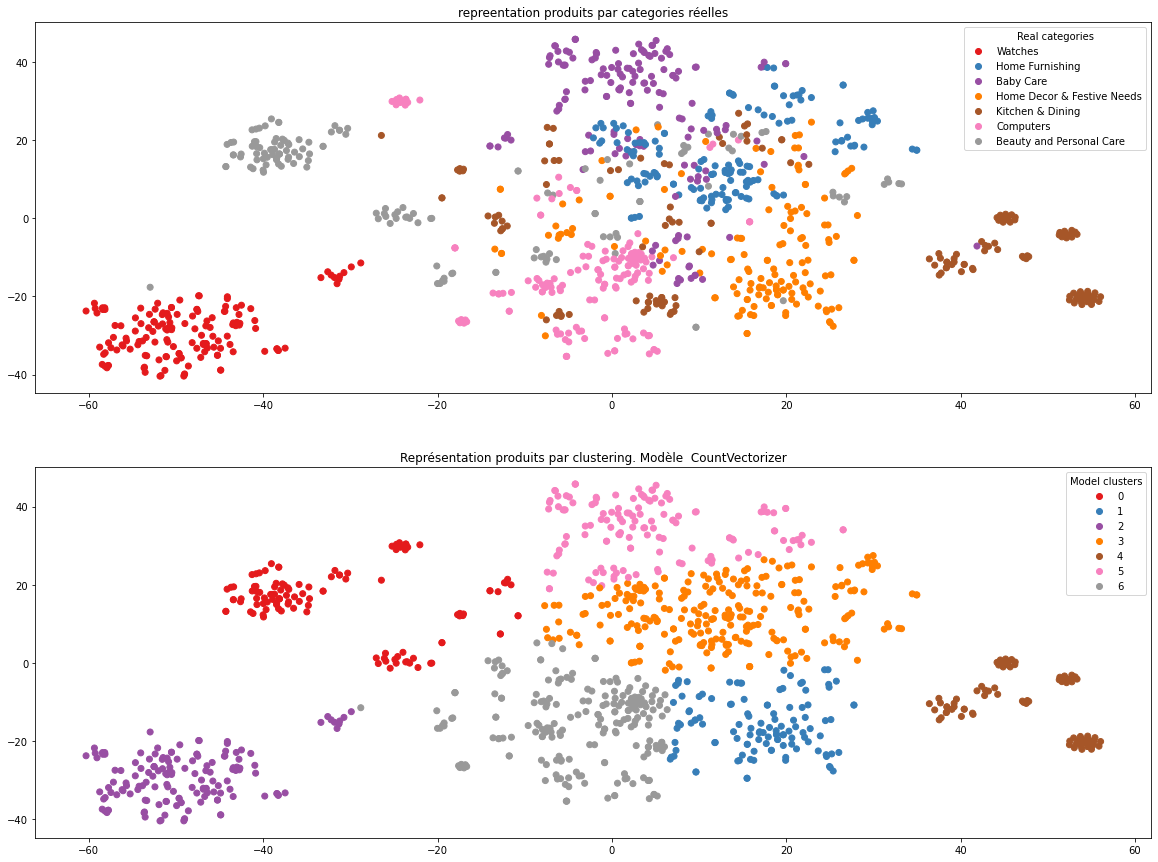

ARI :  0.4817
                                                    Tf-idf
Préprocessing  0  : Minuscule-tokenization
Dimmensions de la matrice Tf-idf : (1050, 2444)
ARI :  0.5083 time :  14.0

Préprocessing  1  : Minuscule-tokenization-stopWords
Dimmensions de la matrice Tf-idf : (1050, 2332)
ARI :  0.4867 time :  15.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
Dimmensions de la matrice Tf-idf : (1050, 2175)
ARI :  0.5442 time :  14.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
Dimmensions de la matrice Tf-idf : (1050, 1953)
ARI :  0.5154 time :  16.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-Adverbes
Dimmensions de la matrice Tf-idf : (1050, 1914)
ARI :  0.5255 time :  14.0



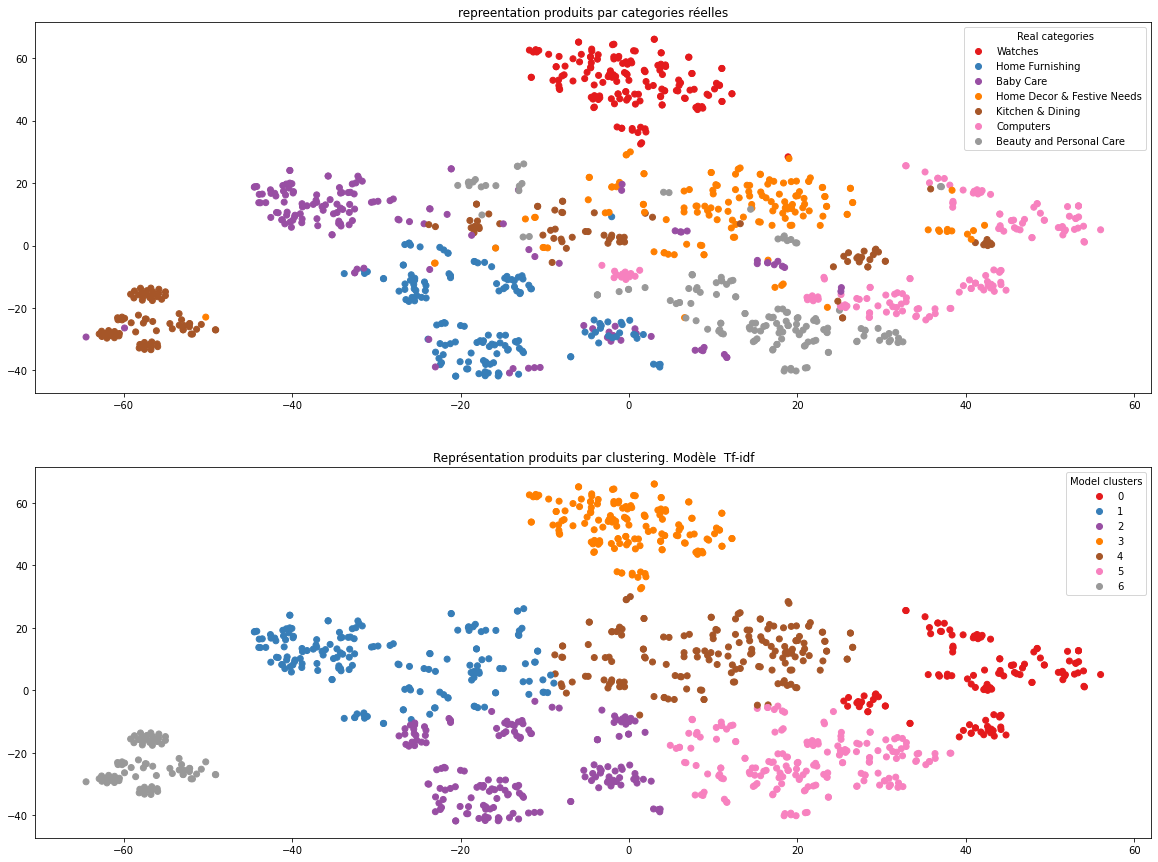

ARI :  0.5442
                                                    Word2Vec
Préprocessing  0  : Minuscule-tokenization
Build & train Word2Vec model ...
Vocabulary size: 5193
Word2Vec trained 

Preparation of sentences (tokenization)
----------------------------------------
Number of unique words: 5194 

Create Embedding matrix ...
-------------------------------
Word embedding rate :  1.0
Embedding matrix: (5194, 300) 

Creation of the embedding model
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 446)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 446, 300)          1558200   
                                                                 
 global_average_pooling1d_5   (None, 300)              0         
 (GlobalAveragePooling1D)                                        


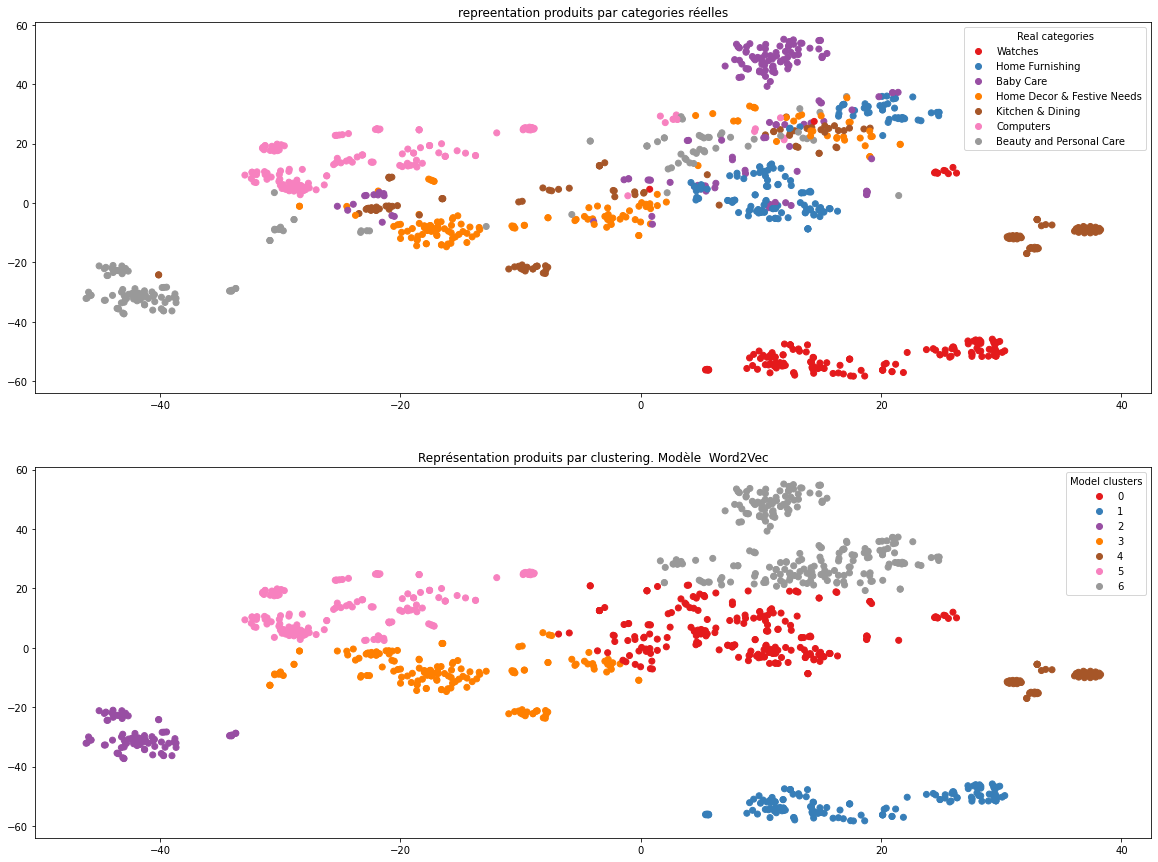

ARI :  0.4606
                                                    BERT
tf version :  2.8.0
tensorflow version : 2.8.0
Num GPUs Available:  0
True
                                              Mode : TFhub
Préprocessing  0  : Minuscule-tokenization
temps traitement :  198.0
ARI :  0.3194 time :  12.0

Préprocessing  1  : Minuscule-tokenization-stopWords
temps traitement :  203.0
ARI :  0.3388 time :  13.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
temps traitement :  196.0
ARI :  0.3368 time :  17.0
Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
temps traitement :  245.0
ARI :  0.334 time :  15.0
Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-Adverbes
temps traitement :  301.0
ARI :  0.3483 time :  18.0



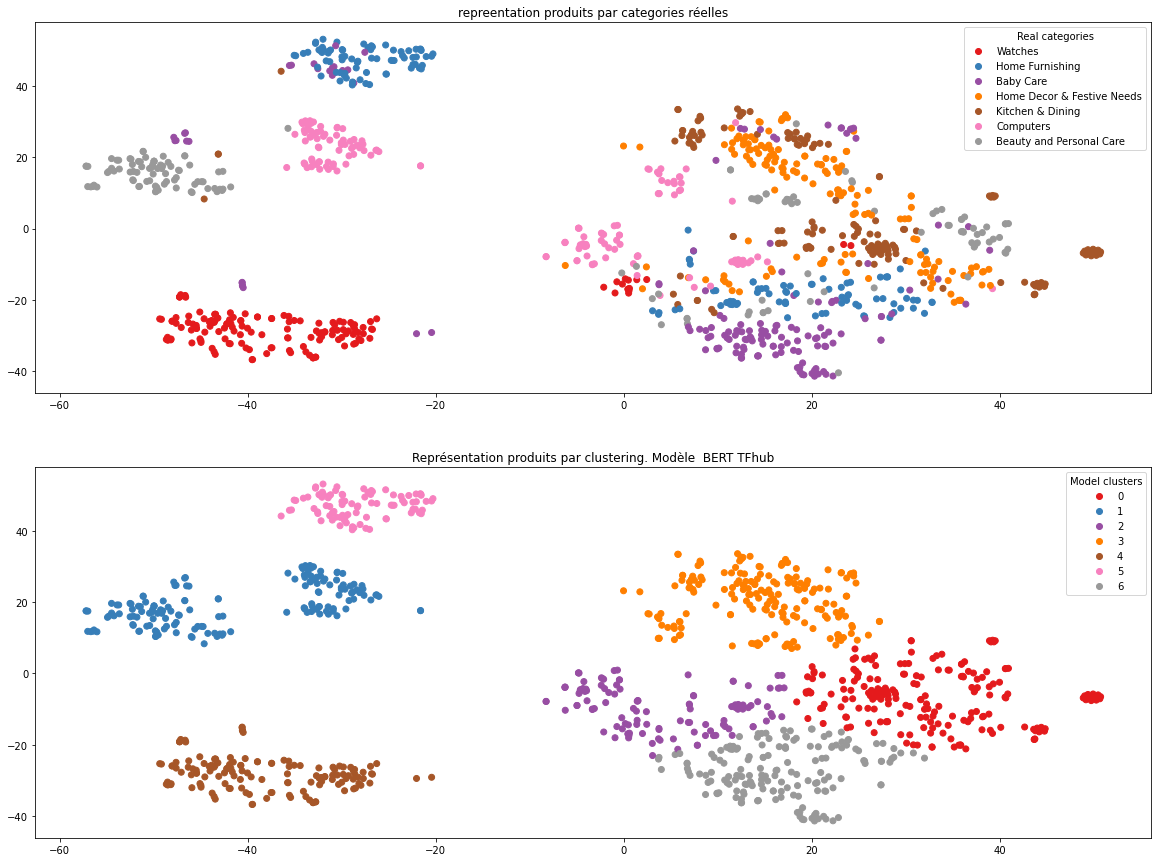

ARI :  0.3483
                                                    USE
2.8.0
2.8.0
Num GPUs Available:  0
True
Préprocessing  0  : Minuscule-tokenization
ARI :  0.4318 time :  16.0

Préprocessing  1  : Minuscule-tokenization-stopWords
ARI :  0.4198 time :  16.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
ARI :  0.388 time :  19.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
ARI :  0.4364 time :  18.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-Adverbes
ARI :  0.4007 time :  17.0



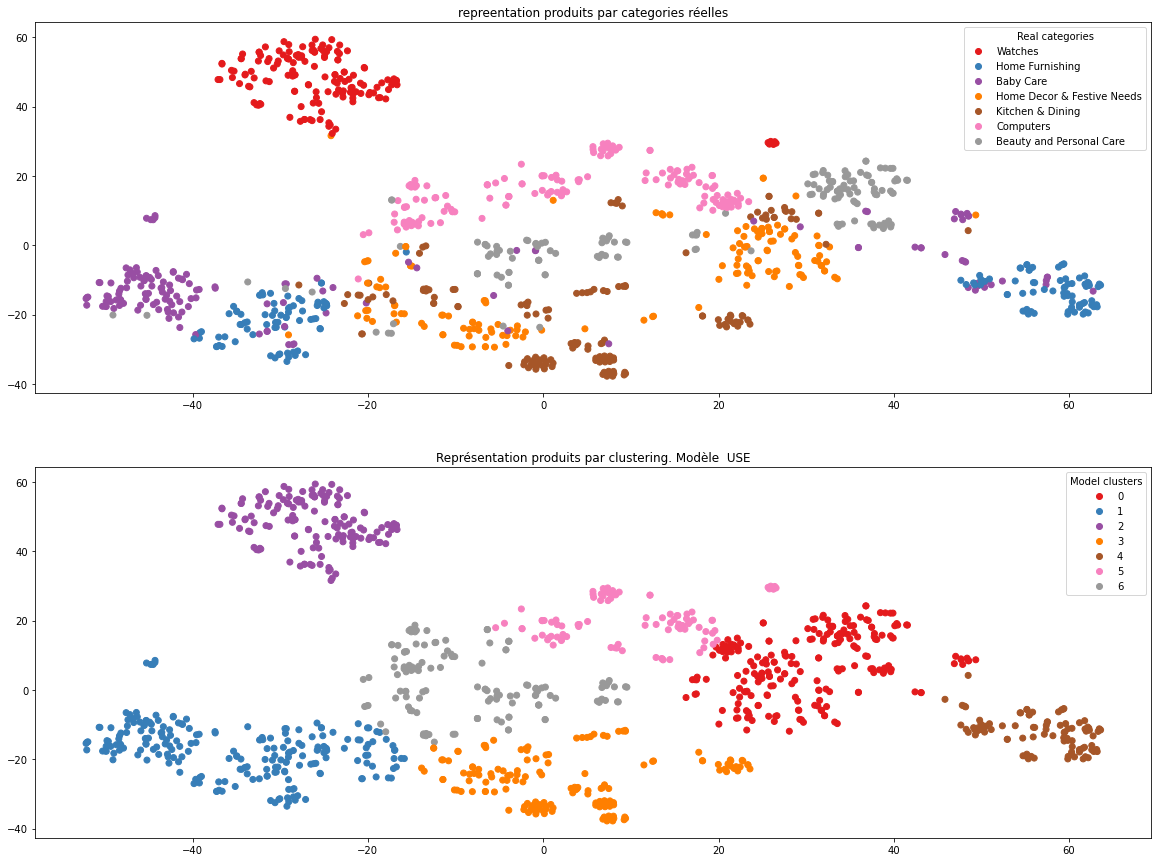

ARI :  0.4364


In [45]:
############## CountVectorizer ###################################
for methode in range(len(methodes)):
    print('============================================================================================================================')
    print("                                                   ",methodes[methode])
    print('============================================================================================================================')
    ari_init=0   
    ################################################## CountVectorizer  ##############################################
    if methodes[methode] =='CountVectorizer':
        for i in range(len(feat)):
            cv_fit = cvect.fit(data[feat[i]])
            cv_transform = cvect.transform(data[feat[i]])   
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            print("Dimmensions de la matrice", methodes[methode], ":",cv_transform.shape)
            ARI, X_tsne, labels = ARI_fct(cv_transform)
            if ARI > ari_init:
                ari_init=ARI
            print("")
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])   
    ################################################## Tf-idf  ##############################################        
    elif  methodes[methode] =='Tf-idf':
        for i in range(len(feat)):
            cv_fit = ctf.fit(data[feat[i]])
            cv_transform = ctf.transform(data[feat[i]]) 
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            print("Dimmensions de la matrice",  methodes[methode], ":",cv_transform.shape)
            ARI, X_tsne, labels = ARI_fct(cv_transform)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode]) 
    ################################################## Word2Vec  ##############################################       
    elif methodes[methode] =='Word2Vec':
        for i in range(len(feat)):
            w2v_size=300    # taille du vecteur pour chaque mot
            w2v_window=5    # Distance max entre le moot et ses voisins
            w2v_min_count=1 # fréquence minimale des mots devant être présents dans le vocabulaire
            w2v_epochs=250  # Nombre d'iterration /epochs
            maxlen = 446     # adapt to length of sentences
            sentences = data[feat[i]].to_list()   # Listes des phrases " Listes des descriptions de chaque produit"
            sentences = [gensim.utils.simple_preprocess(text) for text in sentences]      # 1 Liste avec tous les mots 
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================')              
            print("Build & train Word2Vec model ...")
            w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                            vector_size=w2v_size,
                                                            seed=42,
                                                            workers=1)
            #                                                workers=multiprocessing.cpu_count())
            w2v_model.build_vocab(sentences)
            w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
            model_vectors = w2v_model.wv
            w2v_words = model_vectors.index_to_key
            print("Vocabulary size: %i" % len(w2v_words))
            print("Word2Vec trained \n")
            print("Preparation of sentences (tokenization)")
            print('----------------------------------------')
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(sentences)
            x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                                 maxlen=maxlen,
                                                                 padding='post')                                                 
            num_words = len(tokenizer.word_index) + 1
            print("Number of unique words: %i" % num_words,"\n")
            print("Create Embedding matrix ...")
            print('-------------------------------')
            word_index = tokenizer.word_index
            vocab_size = len(word_index) + 1
            embedding_matrix = np.zeros((vocab_size, w2v_size))
            i=0
            j=0

            for word, idx in word_index.items():
                i +=1
                if word in w2v_words:
                    j +=1
                    embedding_vector = model_vectors[word]
                    if embedding_vector is not None:
                        embedding_matrix[idx] = model_vectors[word]

            word_rate = np.round(j/i,4)
            print("Word embedding rate : ", word_rate)
            print("Embedding matrix: %s" % str(embedding_matrix.shape),"\n")    
            print("Creation of the embedding model")    
            print('================================') 
            input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
            word_input=Input(shape=(maxlen,),dtype='float64')  
            word_embedding=Embedding(input_dim=vocab_size,
                                     output_dim=w2v_size,
                                     weights = [embedding_matrix],
                                     input_length=maxlen)(word_input)
            word_vec=GlobalAveragePooling1D()(word_embedding)  
            embed_model = Model([word_input],word_vec)

            embed_model.summary()
            
            embeddings = embed_model.predict(x_sentences)
            embeddings.shape
            
            ARI, X_tsne, labels = ARI_fct(embeddings)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
            
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])                   
    ################################################## BERT  ##############################################
    elif methodes[methode] =='BERT':
        print("tf version : ", tf.__version__)
        print("tensorflow version :", tensorflow.__version__)
        print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
        print(tf.test.is_built_with_cuda())
        
        
        for mode in range(len(modes)):
            print("                                              Mode :",modes[mode])
            for i in range(len(feat)):    
                # BERT hub Tensorflow 
                # Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
                model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
                bert_layer = hub.KerasLayer(model_url, trainable=True)
                sentences = data[feat[i]].to_list() 

                print("Préprocessing ", i," :", preprocessing[i])
                print('============================================================================') 
                max_length = 64
                batch_size = 10
                model_type = 'bert-base-uncased'
                model = bert_layer
                # Création des features
                features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                                         max_length, batch_size, mode=modes[mode])
                ARI, X_tsne, labels = ARI_fct(features_bert)
                if ARI > ari_init:
                    ari_init=ARI
                    print("")  

            TSNE_visu_fct_BERT(X_tsne, y_cat_num, labels, ari_init,methodes[methode],modes[mode]) 
    ################################################## USE  ##############################################    
    elif methodes[methode] =='USE':
        print(tf.__version__)
        print(tensorflow.__version__)
        print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
        print(tf.test.is_built_with_cuda())
        for i in range(len(feat)): 
            embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
            batch_size = 10
            sentences = data[feat[i]].to_list()
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            features_USE = feature_USE_fct(sentences, batch_size)
            ARI, X_tsne, labels = ARI_fct(features_USE)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])

## Essayons maintenant de voir si en fusionnant le nom du produit "product_name" avec la "description" cela améliore notre résultat de clustering automatique : 

### merge of data : 

In [46]:
data.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,...,cat_lvl_2,cat_lvl_3,description_bow,description_bow_lem,description_bow_lem_removal_numbers,description_dl,description_bow_lem_removal_numbers_adverbs,length_bow,length_dl,length_bow_lem
154,63f6ef8f3fda2c306b27cfbf5a005f1e,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-cute-beauti...,Rockmantra Cute Beautiful Girl Playing With He...,MUGEAGGKZFYBUMP9,499.0,199.0,63f6ef8f3fda2c306b27cfbf5a005f1e.jpg,False,Rockmantra Cute Beautiful Girl Playing With He...,...,Coffee Mugs,Rockmantra Coffee Mugs,rockmantra cute beautiful girl playing with he...,rockmantra cute beautiful girl playing with he...,rockmantra cute beautiful girl playing with he...,rockmantra cute beautiful girl playing with he...,rockmantra cute beautiful girl playing with he...,77,145,77
320,3ee79b1e51c9f9262e8373ce6b717606,2015-12-01 06:13:00 +0000,http://www.flipkart.com/layer-r-shot-compact-i...,"Layer'r Shot Compact Impact ,Explode And Turbo...",CAGEBFPETZZDWEBZ,375.0,355.0,3ee79b1e51c9f9262e8373ce6b717606.jpg,False,Flipkart.com: Buy Layer'r Shot Compact Impact ...,...,Fragrances,Deodorants,flipkart.com buy layer shot compact impact exp...,flipkart.com buy layer shot compact impact exp...,flipkart.com buy layer shot compact impact exp...,flipkart.com : buy layer ' r shot compact impa...,flipkart.com buy layer shot compact impact exp...,27,47,27
265,412d0425bb7076610aace6549ded265c,2015-12-01 12:40:44 +0000,http://www.flipkart.com/lal-haveli-rajasthani-...,Lal Haveli Rajasthani Handmade Vintage Wooden ...,SHIE9J6PYVBW5ATG,2000.0,1499.0,412d0425bb7076610aace6549ded265c.jpg,False,Lal Haveli Rajasthani Handmade Vintage Wooden ...,...,Showpieces,Ethnic,lal haveli rajasthani handmade vintage wooden ...,lal haveli rajasthani handmade vintage wooden ...,lal haveli rajasthani handmade vintage wooden ...,lal haveli rajasthani handmade vintage wooden ...,lal haveli rajasthani handmade vintage wooden ...,73,128,73


In [47]:
data['Full_Name'] = data[['product_name', 'description']].apply(' '.join, axis=1)

## cleaning up the text :

In [48]:
data['description_bow'] = data['Full_Name'].apply(lambda x : transform_bow_fct(x))
data['description_bow_lem'] = data['Full_Name'].apply(lambda x : transform_bow_lem_fct(x))
data['description_bow_lem_removal_numbers'] = data['Full_Name'].apply(lambda x : transform_bow_lem_removal_numbers_fct(x))
data['description_dl'] = data['Full_Name'].apply(lambda x : transform_dl_fct(x))
data['description_bow_lem_removal_numbers_adverbs'] = data['Full_Name'].apply(lambda x : transform_bow_lem_removal_numbers_adverbs_fct(x))

In [49]:
data['description_bow'][2] 

'eurospa cotton terry face towel set key features eurospa cotton terry face towel set size small height inch gsm 360 eurospa cotton terry face towel set piece face towel set assorted price 299 eurospa brings exclusively designed 100 soft cotton towels export quality all products soft texture takes care skin enriched feeling deserve eurospa exporting bath towels lot renowned brands years famous fine prints absorbency softness durability note our product 100 cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cms cms. specifications eurospa cotton terry face towel set piece face towel set assorted bath towel features material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model name shuvam20pcftsetassorted ideal for boys girls men women model shuvam20pcftsetassorted size small color assorted dimensions weight 350 length inch width inch box number contents sales package sales pa

In [50]:
data['description_bow_lem'][2] 

'eurospa cotton terry face towel set key feature eurospa cotton terry face towel set size small height inch gsm 360 eurospa cotton terry face towel set piece face towel set assorted price 299 eurospa brings exclusively designed 100 soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product 100 cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm 360 type face towel set model name shuvam20pcftsetassorted ideal for boy girl men woman model shuvam20pcftsetassorted size small color assorted dimension weight 350 length inch width inch box number content sale package sale package piece face 

In [51]:
data['description_dl'][2] 

'eurospa cotton terry face towel set key features of eurospa cotton terry face towel set size : small height : 9 inch gsm : 360 , eurospa cotton terry face towel set ( 20 piece face towel set , assorted ) price : rs . 299 eurospa brings to you an exclusively designed , 100 % soft cotton towels of export quality . all our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve . eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints , absorbency , softness and durability . note : our product is 100 % cotton , so it is susceptible to shrinkage . product color may vary from the picture . size may vary by ±3 % wash care : wash in cold water , do not iron , do not bleach , flat dry , wash before first use . size face towel 23 cms x 23 cms. , specifications of eurospa cotton terry face towel set ( 20 piece face towel set , assorted ) bath towel features material cotton terry desi

In [52]:
data['description_bow_lem_removal_numbers'][2] 

'eurospa cotton terry face towel set key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings exclusively designed soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvam pcftsetassorted ideal for boy girl men woman model shuvam pcftsetassorted size small color assorted dimension weight length inch width inch box number content sale package sale package piece face towel set'

In [53]:
data['description_bow_lem_removal_numbers_adverbs'][2] 

'eurospa cotton terry face towel set key feature eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face towel set piece face towel set assorted price eurospa brings designed soft cotton towel export quality all product soft texture take care skin enriched feeling deserve eurospa exporting bath towel lot renowned brand year famous fine print absorbency softness durability note our product cotton susceptible shrinkage product color vary picture size vary wash care wash cold water iron bleach flat dry wash size face towel cm cms. specification eurospa cotton terry face towel set piece face towel set assorted bath towel feature material cotton terry design shuvam general brand eurospa gsm type face towel set model name shuvam pcftsetassorted ideal for boy girl men woman model shuvam pcftsetassorted size small color assorted dimension weight length inch width inch box number content sale package sale package piece face towel set'

In [54]:
l_cat = list(set(data['cat_lvl_1']))
print("categories : ", l_cat)
y_cat_num = [(l_cat.index(data.iloc[i]['cat_lvl_1'])) for i in range(len(data))]

categories :  ['Watches', 'Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Computers', 'Beauty and Personal Care']


In [55]:
from nltk.tokenize import sent_tokenize, word_tokenize
data['length_bow'] = data['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data['length_bow'].max())

data['length_dl'] = data['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data['length_dl'].max())

max length bow :  369
max length dl :  637


In [56]:
data['length_bow_lem'] = data['description_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem  : ", data['length_bow_lem'].max())

max length bow_lem  :  369


# 1. Bag of word :

### 1.1 essais avec les 5 preprocessing : 

1-> Préprocessing 0 = Minuscules, tokenization

2-> Préprocessing 1 = Minuscules, tokenization, stopWords

3-> Préprocessing 2 = Minuscules, tokenization, stopWords, lemmatization

4-> Préprocessing 3 = Minuscules, tokenization, stopWords, lemmatization, numbers

5-> Preprocessing 4 = Minuscules, tokenization, stopWords, lemmatization, numbers, Adverbes

In [57]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

methodes=['CountVectorizer','Tf-idf', 'Word2Vec','BERT', 'USE']
models=['cvect','ctf']
feat = ['description_dl', 'description_bow', 'description_bow_lem', 'description_bow_lem_removal_numbers','description_bow_lem_removal_numbers_adverbs']
preprocessing=['Minuscule-tokenization', 'Minuscule-tokenization-stopWords', 'Minuscule-tokenization-stopWords-lemmatization', 'Minuscule-tokenization-stopWords-lemmatization-numbers','Minuscule-tokenization-stopWords-lemmatization-numbers-adverbs']
modes=['TFhub']# ,'HF'

### creation of "bag of words" ( CountVectorizer, TF-IDF) + Word2Vec+BERT + USE

                                                    CountVectorizer
Préprocessing  0  : Minuscule-tokenization
Dimmensions de la matrice CountVectorizer : (1050, 5844)
ARI :  0.4351 time :  11.0

Préprocessing  1  : Minuscule-tokenization-stopWords
Dimmensions de la matrice CountVectorizer : (1050, 5669)
ARI :  0.5144 time :  19.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
Dimmensions de la matrice CountVectorizer : (1050, 5290)
ARI :  0.4201 time :  19.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
Dimmensions de la matrice CountVectorizer : (1050, 4409)
ARI :  0.4419 time :  18.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-adverbs
Dimmensions de la matrice CountVectorizer : (1050, 4316)
ARI :  0.4749 time :  18.0



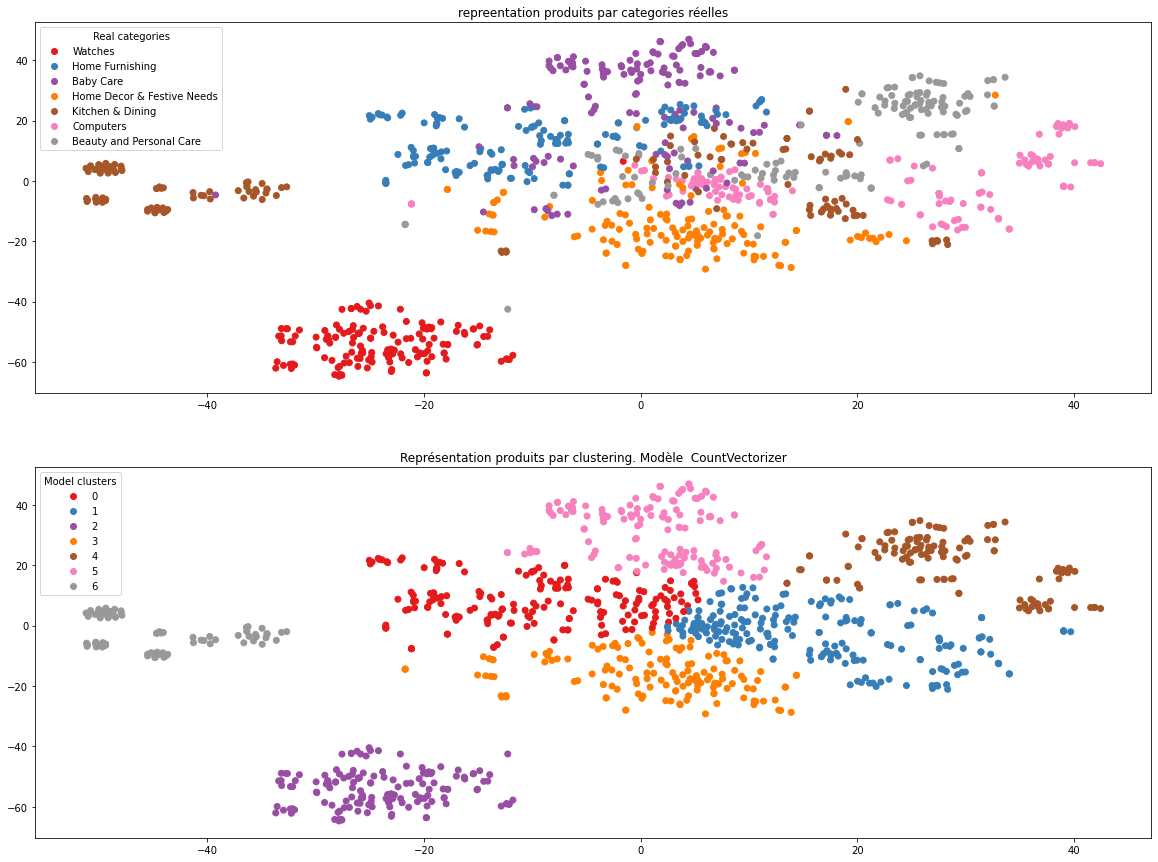

ARI :  0.5144
                                                    Tf-idf
Préprocessing  0  : Minuscule-tokenization
Dimmensions de la matrice Tf-idf : (1050, 2444)
ARI :  0.6201 time :  18.0

Préprocessing  1  : Minuscule-tokenization-stopWords
Dimmensions de la matrice Tf-idf : (1050, 2332)
ARI :  0.5463 time :  17.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
Dimmensions de la matrice Tf-idf : (1050, 2175)
ARI :  0.6062 time :  19.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
Dimmensions de la matrice Tf-idf : (1050, 1953)
ARI :  0.5393 time :  17.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-adverbs
Dimmensions de la matrice Tf-idf : (1050, 1914)
ARI :  0.5889 time :  16.0



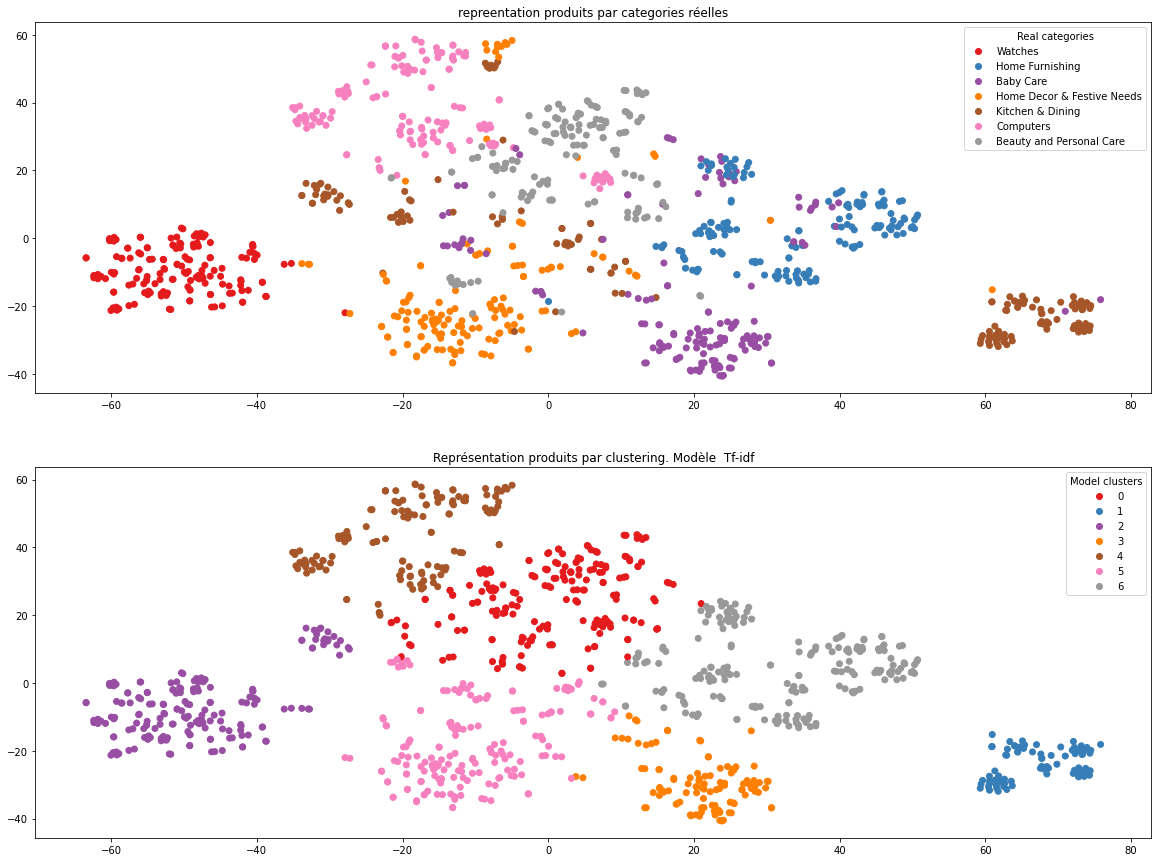

ARI :  0.6201
                                                    Word2Vec
Préprocessing  0  : Minuscule-tokenization
Build & train Word2Vec model ...
Vocabulary size: 5193
Word2Vec trained 

Preparation of sentences (tokenization)
----------------------------------------
Number of unique words: 5194 

Create Embedding matrix ...
-------------------------------
Word embedding rate :  1.0
Embedding matrix: (5194, 300) 

Creation of the embedding model
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 446)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 446, 300)          1558200   
                                                                 
 global_average_pooling1d_10  (None, 300)              0         
  (GlobalAveragePooling1D)                                       

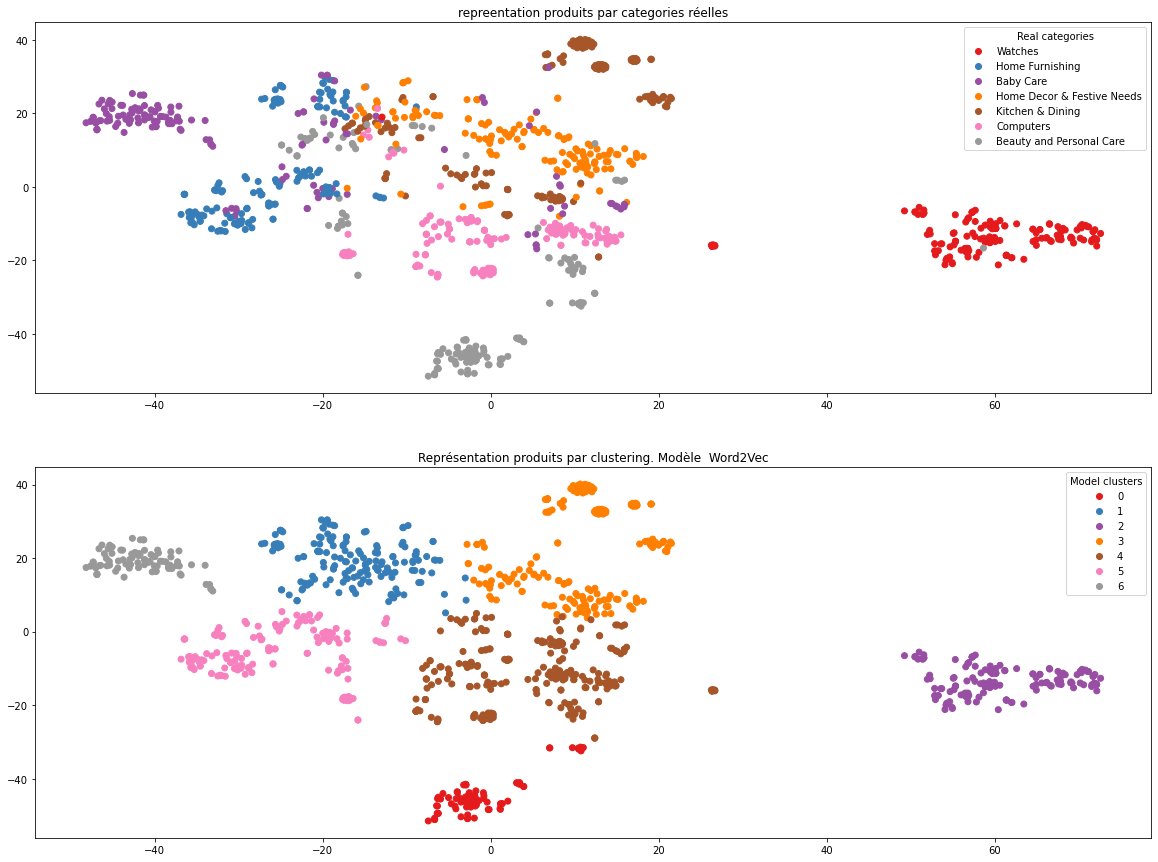

ARI :  0.4324
                                                    BERT
tf version :  2.8.0
tensorflow version : 2.8.0
Num GPUs Available:  0
True
                                              Mode : TFhub
Préprocessing  0  : Minuscule-tokenization
temps traitement :  279.0
ARI :  0.4029 time :  19.0

Préprocessing  1  : Minuscule-tokenization-stopWords
temps traitement :  281.0
ARI :  0.3615 time :  18.0
Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
temps traitement :  252.0
ARI :  0.4047 time :  14.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
temps traitement :  235.0
ARI :  0.3642 time :  15.0
Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-adverbs
temps traitement :  238.0
ARI :  0.3699 time :  14.0


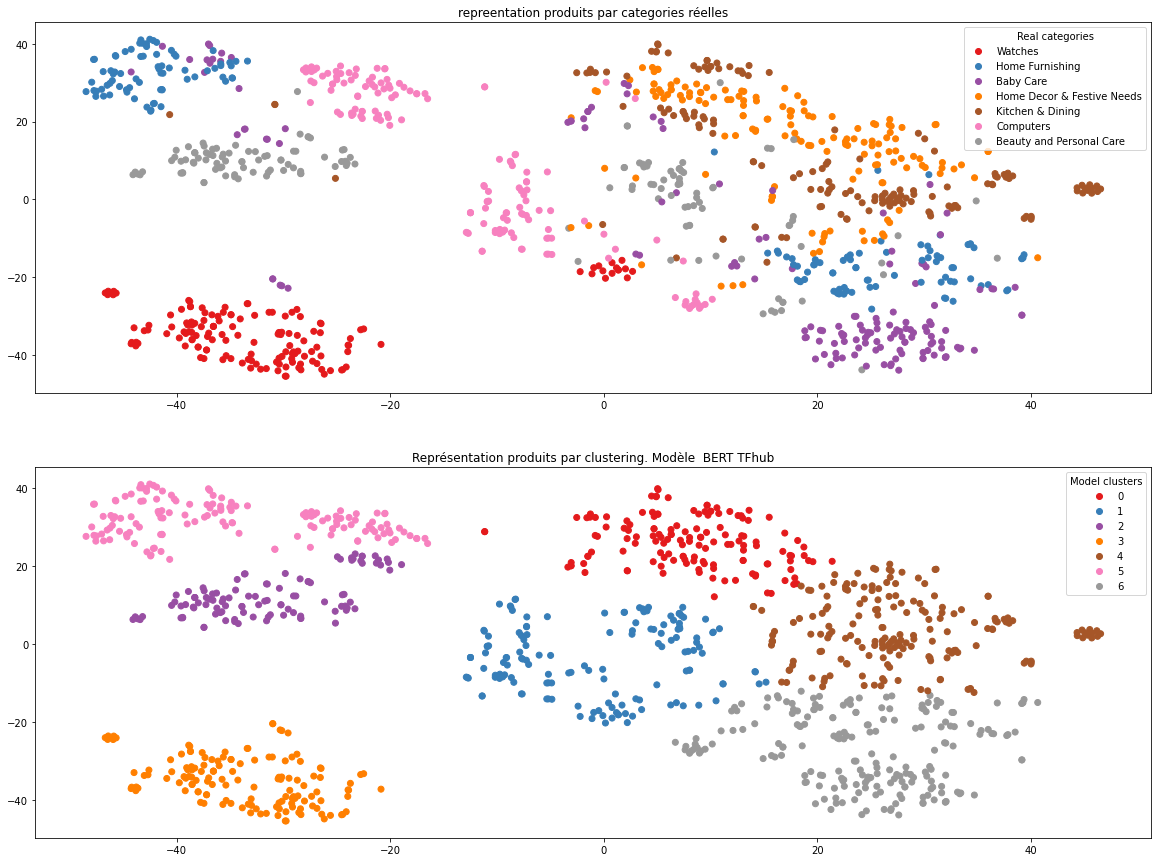

ARI :  0.4047
                                                    USE
2.8.0
2.8.0
Num GPUs Available:  0
True
Préprocessing  0  : Minuscule-tokenization
ARI :  0.4028 time :  13.0

Préprocessing  1  : Minuscule-tokenization-stopWords
ARI :  0.4187 time :  14.0

Préprocessing  2  : Minuscule-tokenization-stopWords-lemmatization
ARI :  0.4364 time :  14.0

Préprocessing  3  : Minuscule-tokenization-stopWords-lemmatization-numbers
ARI :  0.4198 time :  15.0

Préprocessing  4  : Minuscule-tokenization-stopWords-lemmatization-numbers-adverbs
ARI :  0.4813 time :  15.0



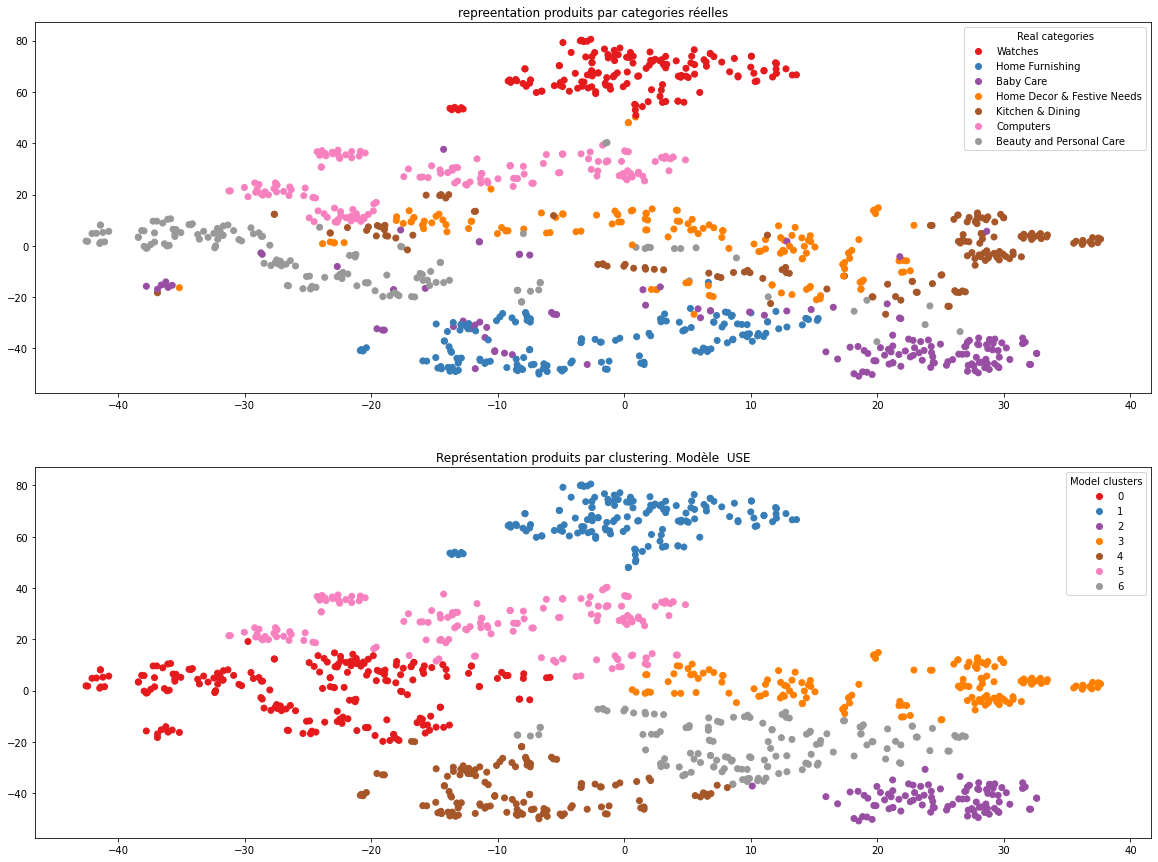

ARI :  0.4813


In [58]:
############## CountVectorizer ###################################
for methode in range(len(methodes)):
    print('============================================================================================================================')
    print("                                                   ",methodes[methode])
    print('============================================================================================================================')
    ari_init=0   
    ################################################## CountVectorizer  ##############################################
    if methodes[methode] =='CountVectorizer':
        for i in range(len(feat)):
            cv_fit = cvect.fit(data[feat[i]])
            cv_transform = cvect.transform(data[feat[i]])   
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            print("Dimmensions de la matrice", methodes[methode], ":",cv_transform.shape)
            ARI, X_tsne, labels = ARI_fct(cv_transform)
            if ARI > ari_init:
                ari_init=ARI
            print("")
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])   
    ################################################## Tf-idf  ##############################################        
    elif  methodes[methode] =='Tf-idf':
        for i in range(len(feat)):
            cv_fit = ctf.fit(data[feat[i]])
            cv_transform = ctf.transform(data[feat[i]]) 
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            print("Dimmensions de la matrice",  methodes[methode], ":",cv_transform.shape)
            ARI, X_tsne, labels = ARI_fct(cv_transform)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode]) 
    ################################################## Word2Vec  ##############################################       
    elif methodes[methode] =='Word2Vec':
        for i in range(len(feat)):
            w2v_size=300    # taille du vecteur pour chaque mot
            w2v_window=5    # Distance max entre le moot et ses voisins
            w2v_min_count=1 # fréquence minimale des mots devant être présents dans le vocabulaire
            w2v_epochs=250  # Nombre d'iterration /epochs
            maxlen = 446     # adapt to length of sentences
            sentences = data[feat[i]].to_list()   # Listes des phrases " Listes des descriptions de chaque produit"
            sentences = [gensim.utils.simple_preprocess(text) for text in sentences]      # 1 Liste avec tous les mots 
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================')              
            print("Build & train Word2Vec model ...")
            w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                            vector_size=w2v_size,
                                                            seed=42,
                                                            workers=1)
            #                                                workers=multiprocessing.cpu_count())
            w2v_model.build_vocab(sentences)
            w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
            model_vectors = w2v_model.wv
            w2v_words = model_vectors.index_to_key
            print("Vocabulary size: %i" % len(w2v_words))
            print("Word2Vec trained \n")
            print("Preparation of sentences (tokenization)")
            print('----------------------------------------')
            tokenizer = Tokenizer()
            tokenizer.fit_on_texts(sentences)
            x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                                 maxlen=maxlen,
                                                                 padding='post')                                                 
            num_words = len(tokenizer.word_index) + 1
            print("Number of unique words: %i" % num_words,"\n")
            print("Create Embedding matrix ...")
            print('-------------------------------')
            word_index = tokenizer.word_index
            vocab_size = len(word_index) + 1
            embedding_matrix = np.zeros((vocab_size, w2v_size))
            i=0
            j=0

            for word, idx in word_index.items():
                i +=1
                if word in w2v_words:
                    j +=1
                    embedding_vector = model_vectors[word]
                    if embedding_vector is not None:
                        embedding_matrix[idx] = model_vectors[word]

            word_rate = np.round(j/i,4)
            print("Word embedding rate : ", word_rate)
            print("Embedding matrix: %s" % str(embedding_matrix.shape),"\n")    
            print("Creation of the embedding model")    
            print('================================') 
            input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
            word_input=Input(shape=(maxlen,),dtype='float64')  
            word_embedding=Embedding(input_dim=vocab_size,
                                     output_dim=w2v_size,
                                     weights = [embedding_matrix],
                                     input_length=maxlen)(word_input)
            word_vec=GlobalAveragePooling1D()(word_embedding)  
            embed_model = Model([word_input],word_vec)

            embed_model.summary()
            
            embeddings = embed_model.predict(x_sentences)
            embeddings.shape
            
            ARI, X_tsne, labels = ARI_fct(embeddings)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
            
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])                   
    ################################################## BERT  ##############################################
    elif methodes[methode] =='BERT':
        print("tf version : ", tf.__version__)
        print("tensorflow version :", tensorflow.__version__)
        print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
        print(tf.test.is_built_with_cuda())
        
        
        for mode in range(len(modes)):
            print("                                              Mode :",modes[mode])
            for i in range(len(feat)):    
                # BERT hub Tensorflow 
                # Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
                model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
                bert_layer = hub.KerasLayer(model_url, trainable=True)
                sentences = data[feat[i]].to_list() 

                print("Préprocessing ", i," :", preprocessing[i])
                print('============================================================================') 
                max_length = 64
                batch_size = 10
                model_type = 'bert-base-uncased'
                model = bert_layer
                # Création des features
                features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                                         max_length, batch_size, mode=modes[mode])
                ARI, X_tsne, labels = ARI_fct(features_bert)
                if ARI > ari_init:
                    ari_init=ARI
                    print("")  

            TSNE_visu_fct_BERT(X_tsne, y_cat_num, labels, ari_init,methodes[methode],modes[mode]) 
    ################################################## USE  ##############################################    
    elif methodes[methode] =='USE':
        print(tf.__version__)
        print(tensorflow.__version__)
        print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
        print(tf.test.is_built_with_cuda())
        for i in range(len(feat)): 
            embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
            batch_size = 10
            sentences = data[feat[i]].to_list()
            print("Préprocessing ", i," :", preprocessing[i])
            print('============================================================================') 
            features_USE = feature_USE_fct(sentences, batch_size)
            ARI, X_tsne, labels = ARI_fct(features_USE)
            if ARI > ari_init:
                ari_init=ARI
            print("")  
        TSNE_visu_fct(X_tsne, y_cat_num, labels, ari_init,methodes[methode])

# Conclusion :

Tous les tests montrent qu'il est faisable d'attribuer automatiquement des catégories aux produits à travaers leur description/description + nom_produit. 